In [27]:
import numpy as np
from numpy import log, sin, cos, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
import meshio
from pyqtree import Index
import matplotlib.pyplot as plt


In [45]:
def read_geo_gmsh(fname, dir_groups, neu_groups):
    """Read the geometry from a Gmsh file with physical groups

    Parameters
    ----------
    fname : str
        Path to the mesh file.
    dir_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.
    neu_groups : list
        List with the number of the physical groups associated
        with Dirichlet boundary conditions.

    Returns
    -------
    mesh : meshio Mesh object
        Mesh object.
    coords : ndarray, float
        Coordinates for the endpoints of the elements in the
        boundary.
    elems : ndarray, int
        Connectivity for the elements.
    x_m : ndarray, float
        Horizontal component of the midpoint of the elements.
    y_m : ndarray, float
        Vertical component of the midpoint of the elements.
    id_dir : list
        Identifiers for elements with Dirichlet boundary conditions.
    id_neu : list
        Identifiers for elements with Neumann boundary conditions.
    """
    mesh = meshio.read(fname)
    elems_dir = np.vstack([mesh.cells[k].data for k in dir_groups])
    if neu_groups is None:
        elems_neu = np.array([])
        elems = elems_dir.copy()
    else:
        elems_neu = np.vstack([mesh.cells[k].data for k in neu_groups])
        elems = np.vstack((elems_dir, elems_neu))
    bound_nodes = list(set(elems.flatten()))
    coords = mesh.points[bound_nodes, :2]
    x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
    id_dir = range(elems_dir.shape[0])
    id_neu = range(elems_dir.shape[0],
                   elems_dir.shape[0] + elems_neu.shape[0])
    return mesh, coords, elems, x_m, y_m, id_dir, id_neu

def calcular_bbox(coords):
    """
    Calcula el bounding box (bbox) a partir de un arreglo de coordenadas.
    
    :param coordenadas: Lista de tuplas (x, y) representando puntos.
    :return: Tupla (x_min, y_min, x_max, y_max) que define el bounding box.
    """

    
    # Inicializar con los valores del primer punto
    x_min = x_max = coords[0][0]
    y_min = y_max = coords[0][1]
    
    # Iterar sobre el resto de los puntos
    for x, y in coords[1:]:
        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_min = min(y_min, y)
        y_max = max(y_max, y)

    bbox = (x_min, y_min, x_max, y_max)
    
    return bbox

def crear_quadtree(coords):
    """
    Crea un QuadTree a partir de una lista de puntos.
    
    :param puntos: Lista de tuplas (x, y) representando los puntos de la malla.
    :param bbox: Tupla (x_min, y_min, x_max, y_max) que define el área del QuadTree.
    :return: Un objeto Index de pyqtree (QuadTree).
    """
    # Crear el índice QuadTree
    bbox = calcular_bbox(coords)
    quadtree = Index(bbox,max_items=10, max_depth=20)
    
    # Insertar cada punto en el QuadTree
    for i, (x, y) in enumerate(coords):
        quadtree.insert(item=i, bbox=(x, y, x, y))
    
    return quadtree, bbox

def graficar_quadtree(quadtree, puntos, bbox):
    """
    Grafica un QuadTree junto con los puntos que contiene.
    
    :param quadtree: Objeto Index de pyqtree (QuadTree).
    :param puntos: Lista de tuplas (x, y) representando los puntos originales.
    :param bbox: Tupla (x_min, y_min, x_max, y_max) que define el área del QuadTree.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    def dibujar_nodo(bbox, depth=0):
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        
        # Dibujar el rectángulo del nodo
        rect = plt.Rectangle((x1, y1), width, height, fill=False)
        ax.add_patch(rect)
        
        # Verificar si hay más subdivisiones
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        
        # Consultar el quadtree para ver si hay puntos en cada cuadrante
        ne = quadtree.intersect((center_x, center_y, x2, y2))
        nw = quadtree.intersect((x1, center_y, center_x, y2))
        se = quadtree.intersect((center_x, y1, x2, center_y))
        sw = quadtree.intersect((x1, y1, center_x, center_y))
        
        # Si hay puntos y no hemos alcanzado una profundidad máxima, seguir subdividiendo
        max_depth = 10  # Puedes ajustar este valor
        if depth < max_depth:
            if ne: dibujar_nodo((center_x, center_y, x2, y2), depth + 1)
            if nw: dibujar_nodo((x1, center_y, center_x, y2), depth + 1)
            if se: dibujar_nodo((center_x, y1, x2, center_y), depth + 1)
            if sw: dibujar_nodo((x1, y1, center_x, center_y), depth + 1)
    
    # Dibujar la estructura del QuadTree
    dibujar_nodo(bbox)
    
    # Dibujar los puntos
    x, y = zip(*puntos)
    ax.scatter(x, y, c='red', s=20)
    
    # Configurar los límites y etiquetas del gráfico
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    ax.set_aspect('equal')
    ax.set_title('Visualización del QuadTree')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()

In [42]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(r"files\disk_20.msh", [0, 1], [2, 3])

In [46]:
quadtree, bbox = crear_quadtree(coords)


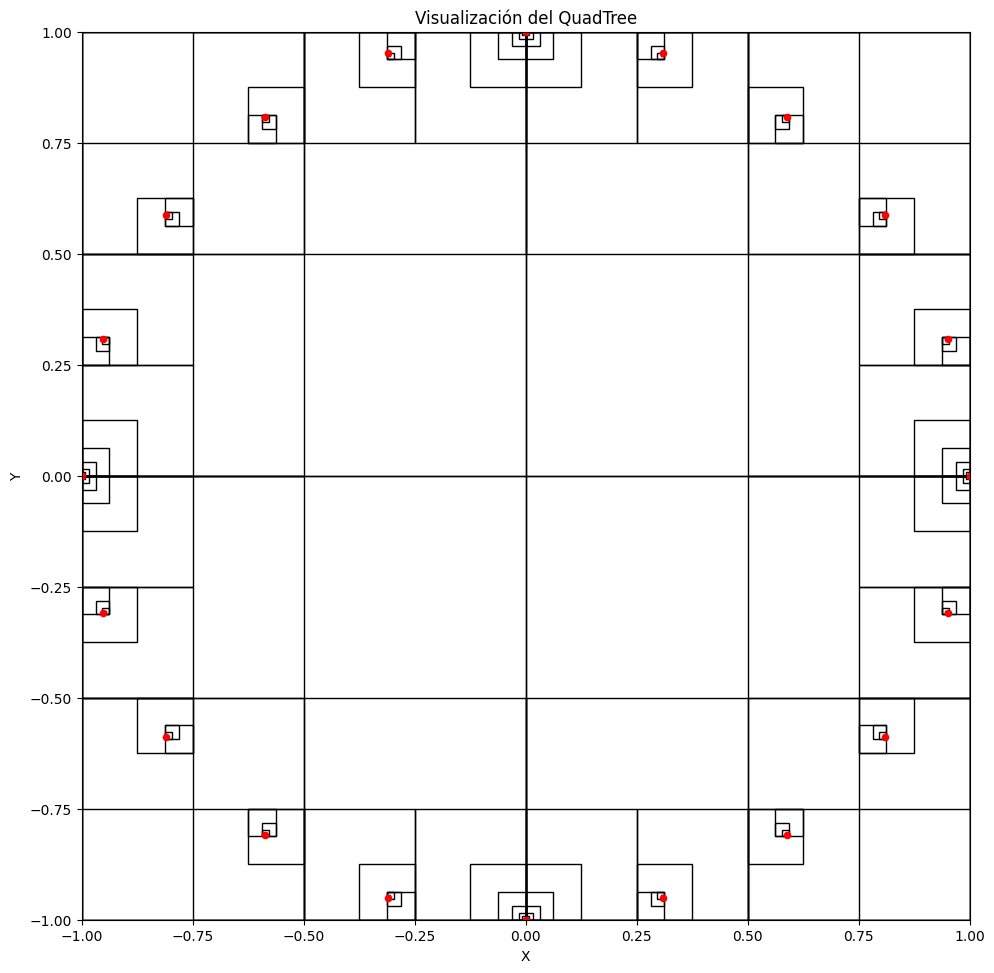

In [47]:
graficar_quadtree(quadtree,coords, bbox)